In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from scipy.special import rel_entr

### change directory to import more scripts
sys.path.append(str(Path().resolve().parents[0]))

from utils import tools
import generate_wind

if os.getcwd().split(os.sep)[-1] == 'evaluation':
    os.chdir('..')

In [2]:
config = tools.load_config("config.yaml")

val_dir = os.path.join(config['data']['re_ninja_dir'], 'wind_speed_10m')
synth_dir = os.path.join(config['data']['synth_dir'], 'ex_noise', 'wind_noage')
turbine_dir = config['data']['turbine_dir']
turbine_power = config['data']['turbine_power']
turbine_path = os.path.join(turbine_dir, turbine_power)
specs_path = config['data']['turbine_specs']
specs_path = os.path.join(turbine_dir, specs_path)
cp_path = config["data"]["turbine_cp"]
cp_path = os.path.join(turbine_dir, cp_path)
results_dir = 'results'

os.makedirs(results_dir, exist_ok=True)

features = config['features']

params = config['wind_params']

mapping = {'power_t1': 'Enercon E-70 E4 2.300',
           'power_t2': 'Enercon E-82 E2 2.000',
           'power_t3': 'Enercon E-115 2.500',
           'power_t4': 'Vestas V90',
           'power_t5': 'Vestas V112-3.45',
           'power_t6': 'Vestas V80-1.8'
           }

turbine_mapping = {'electricity_1': 'power_t1',
                    'electricity_2': 'power_t2',
                    'electricity_3': 'power_t3',
                    'electricity_4': 'power_t4',
                    'electricity_5': 'power_t5',
                    'electricity_6': 'power_t6'
                    }

In [4]:
# get validationd data
files = os.listdir(val_dir)
station_files = [f for f in files if 'metadata' not in f and f.endswith('.csv')]
station_files.sort()
print(len(station_files), 'station files in validation data found')

files = os.listdir(synth_dir)
station_files_synthetic = [f for f in files if 'parameter' not in f and f.endswith('.csv')]
station_files_synthetic.sort()
print(len(station_files_synthetic), 'station files in synthetic data found')
turbine_params = pd.read_csv(os.path.join(synth_dir, 'turbine_parameter.csv'), sep=';')
wind_params = pd.read_csv(os.path.join(synth_dir, 'wind_parameter.csv'), sep=';', dtype={"park_id": str})

raw_power_curves, cp_curves, specs = generate_wind.get_turbines(turbine_path=turbine_path,
                                                        cp_path=cp_path,
                                                        specs_path=specs_path,
                                                        params=params)
power_curves = pd.DataFrame()
for turbine in raw_power_curves.columns:
    power_curve = generate_wind.interpolate(power_curve=raw_power_curves[turbine],
                                            cut_out=specs[turbine]['cut_out'])
    power_curves[turbine] = power_curve
power_curves /= 1000 # convert to kW

110 station files in validation data found
110 station files in synthetic data found


In [5]:
# filter the list
filtered_list = [
    synth for synth in station_files_synthetic
    if any(synth.split('_')[1].split('.')[0] in station for station in station_files)
]
station_files_synthetic = filtered_list

In [6]:
val_dfs = []
dfs = []

for st in station_files:
    station = pd.read_csv(os.path.join(val_dir, st))
    station['datetime'] = pd.to_datetime(station['datetime'], utc=True)
    station.set_index('datetime', inplace=True)
    #metadata = pd.read_csv(os.path.join(path, md))
    val_dfs.append(station)

for st in station_files_synthetic:
    station = pd.read_csv(os.path.join(synth_dir, st), sep=';')
    station['timestamp'] = pd.to_datetime(station['timestamp'], utc=True)
    station.set_index('timestamp', inplace=True)
    station = station['2024-01-01':'2024-12-31']
    for key, value in turbine_mapping.items():
        station[value] /= 1000 # convert to kW
    #metadata = pd.read_csv(os.path.join(path, md))
    dfs.append(station)

In [27]:
def plot_wind_speed_distribution(data_a, data_b, save_path=None):
    fontsize = 14

    sns.histplot(data=data_a, stat='density', x='wind_speed', label=f'measured 10m', bins=50, kde=True)
    sns.histplot(data=data_b, stat='density', x='wind_speed', label=f'renewables.ninja 10m', bins=50, kde=True)

    #plt.title(f'Wind speed @ 10m', fontsize=fontsize)
    plt.xlabel('Wind Speed [m/s]', fontsize=fontsize)
    plt.ylabel('Density', fontsize=fontsize)
    plt.tick_params(axis='both', labelsize=fontsize)
    plt.legend()

    #fig.suptitle('Wind speed distribution', fontsize=fontsize+2)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600)
        plt.close()

def plot_wind_speed_error_distribution(data_a, data_b, save_path=None):
    fontsize = 14

    error = data_b['wind_speed'] - data_a['wind_speed']

    sns.histplot(data=error, stat='density', bins=50, kde=True)

    #plt.title(f'Wind speed @ 10m', fontsize=fontsize)
    plt.xlabel('Wind Speed [m/s]', fontsize=fontsize)
    plt.ylabel('Density', fontsize=fontsize)
    plt.tick_params(axis='both', labelsize=fontsize)

    #fig.suptitle('Wind speed distribution', fontsize=fontsize+2)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600)
        plt.close()

def plot_monthly_boxplots(series: pd.DataFrame,
                          save_path: str = None) -> None:
    monthly_data = [series[series.index.month == m].values for m in range(1, 13)]
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec']
    plt.figure(figsize=(15, 6))
    bp = plt.boxplot(monthly_data, labels=month_labels, showfliers=False, patch_artist=True)
    for box in bp['boxes']:
        box.set(facecolor='lightblue', edgecolor='black')
    for whisker in bp['whiskers']:
        whisker.set(color='black')
    for cap in bp['caps']:
        cap.set(color='black')
    for median in bp['medians']:
        median.set(color='black')

    plt.xlabel("Months")
    plt.ylabel('Bias in Wind Speed [m/s]')
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def plot_wind_speed_boxplots(data: pd.DataFrame,
                          save_path: str = None) -> None:
    plt.figure(figsize=(15, 6))
    groups = data.groupby("wind_speed_bin")["bias"]
    data = [group.values for _, group in groups]
    labels = [5*i for i in range(len(data))]
    bp = plt.boxplot(data, labels=labels, showfliers=False, patch_artist=True)
    for box in bp['boxes']:
        box.set(facecolor='lightblue', edgecolor='black')
    for whisker in bp['whiskers']:
        whisker.set(color='black')
    for cap in bp['caps']:
        cap.set(color='black')
    for median in bp['medians']:
        median.set(color='black')

    plt.xlabel("Wind Speed Bins [m/s]")
    plt.ylabel('Bias in Wind Speed [m/s]')
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def plot_hourly_boxplots(series: pd.DataFrame,
                          save_path: str = None) -> None:
    hourly_data = [series[series.index.hour == h].values for h in range(0, 24)]
    hourly_labels = [f'{i}' for i in range(0, 24)]
    plt.figure(figsize=(15, 6))
    bp = plt.boxplot(hourly_data, labels=hourly_labels, showfliers=False, patch_artist=True)
    for box in bp['boxes']:
        box.set(facecolor='lightblue', edgecolor='black')
    for whisker in bp['whiskers']:
        whisker.set(color='black')
    for cap in bp['caps']:
        cap.set(color='black')
    for median in bp['medians']:
        median.set(color='black')

    plt.xlabel("Hour")
    plt.ylabel('Bias in Wind Speed [m/s]')
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def plot_scatter_wind(data: pd.DataFrame,
                      x: str,
                      hue: str,
                      size: int = 0,
                      label: str = None,
                      save_path: str = None):
    fontsize = 14
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    sns.scatterplot(data=data,
                    x='wind_speed',
                    y='bias',
                    hue=x,
                    palette='coolwarm',
                    #alpha=0.1,
                    size=size,
                    ax=axes[0])
    sns.scatterplot(data=data,
                    x=x,
                    y='bias',
                    hue=hue,
                    palette='viridis',
                    size=size,
                    #alpha=0.1,
                    ax=axes[1])
    axes[0].set_xlabel('Measured Wind Speed [m/s]', fontsize=fontsize)
    axes[0].set_ylabel('Bias (ERA5 - Measured Wind Speed) [m/s]', fontsize=fontsize)
    axes[1].set_xlabel(label, fontsize=fontsize)
    axes[1].set_ylabel('Bias (ERA5 - Measured Wind Speed) [m/s]', fontsize=fontsize)
    #axes[0].legend(title='Temperature', fontsize=fontsize, title_fontsize=fontsize, loc='upper right')
    #axes[1].legend(title='Wind Speed', fontsize=fontsize, title_fontsize=fontsize, loc='lower right')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def compute_kl_divergence(series_p, series_q, bins=50):
    min_val = min(series_p.min(), series_q.min())
    max_val = max(series_p.max(), series_q.max())
    bins = np.linspace(min_val, max_val, bins + 1)
    p_hist, _ = np.histogram(series_p, bins=bins, density=True)
    q_hist, _ = np.histogram(series_q, bins=bins, density=True)
    p_hist += 1e-10
    q_hist += 1e-10
    return np.sum(rel_entr(p_hist, q_hist))

def process_all_stations(
    results_dir,
    station_files,
    dfs,
    val_dfs
):
    distr_base_dir = os.path.join(results_dir, 'wind_speed_10m_distribution')
    boxplot_base_dir = os.path.join(results_dir, 'bias_boxplots')
    error_distr_base_dir = os.path.join(results_dir, 'wind_speed_10m_error_distribution')

    os.makedirs(distr_base_dir, exist_ok=True)
    os.makedirs(boxplot_base_dir, exist_ok=True)
    os.makedirs(error_distr_base_dir, exist_ok=True)

    station_names = []
    stats = []
    diffs = []
    temps = []
    winds = []
    density = []
    time_index = []
    column_names = ['mean_wind_synth',
                    'std_wind_synth',
                    'mean_wind_re_ninja',
                    'std_wind_re_ninja',
                    'kld_synth_to_re_ninja']

    for nr, station in enumerate(station_files):
        station_name = station.split('.')[0].split('_')[1]
        station_names.append(station_name)

        distr_path = os.path.join(distr_base_dir, f'wind_speed_10m_{station_name}.png')
        boxplot_path = os.path.join(boxplot_base_dir, f'monthly_bias_{station_name}.png')
        error_distr_path = os.path.join(error_distr_base_dir, f'wind_speed_10m_error_{station_name}.png')

        bias = val_dfs[nr]['wind_speed'] - dfs[nr]['wind_speed']

        # plot_wind_speed_distribution(data_a=dfs[nr], data_b=val_dfs[nr], save_path=distr_path)
        # plot_wind_speed_error_distribution(data_a=dfs[nr], data_b=val_dfs[nr], save_path=error_distr_path)
        # plot_monthly_boxplots(series=bias, save_path=boxplot_path)

        mean_wind_synth = dfs[nr]['wind_speed'].mean()
        std_wind_synth = dfs[nr]['wind_speed'].std()
        mean_wind_re_ninja = val_dfs[nr]['wind_speed'].mean()
        std_wind_re_ninja = val_dfs[nr]['wind_speed'].std()
        kl_divergence = compute_kl_divergence(dfs[nr]['wind_speed'], val_dfs[nr]['wind_speed'])

        diffs.extend(bias)
        temps.extend(dfs[nr]['temperature_2m'])
        winds.extend(dfs[nr]['wind_speed'])
        density.extend(dfs[nr]['density'])
        time_index.extend(dfs[nr].index)

        stats.append((mean_wind_synth,
                      std_wind_synth,
                      mean_wind_re_ninja,
                      std_wind_re_ninja,
                      kl_divergence))

    results = pd.DataFrame(data=stats, columns=column_names, index=station_names)
    results.index.name = 'station_id'
    results.to_csv(os.path.join(results_dir, 'comparison_in_wind_speed_10m.csv'))
    return pd.Series(diffs, index=time_index), \
           pd.Series(temps, index=time_index), \
           pd.Series(winds, index=time_index), \
           pd.Series(density, index=time_index)

In [8]:
diffs, temps, winds, density = process_all_stations(
    results_dir,
    station_files_synthetic,
    dfs,
    val_dfs
)

In [9]:
if os.path.exists(os.path.join(results_dir, 'wind_speed_10m_distribution')):
    results = pd.read_csv(os.path.join(results_dir, 'comparison_in_wind_speed_10m.csv'), index_col='station_id')

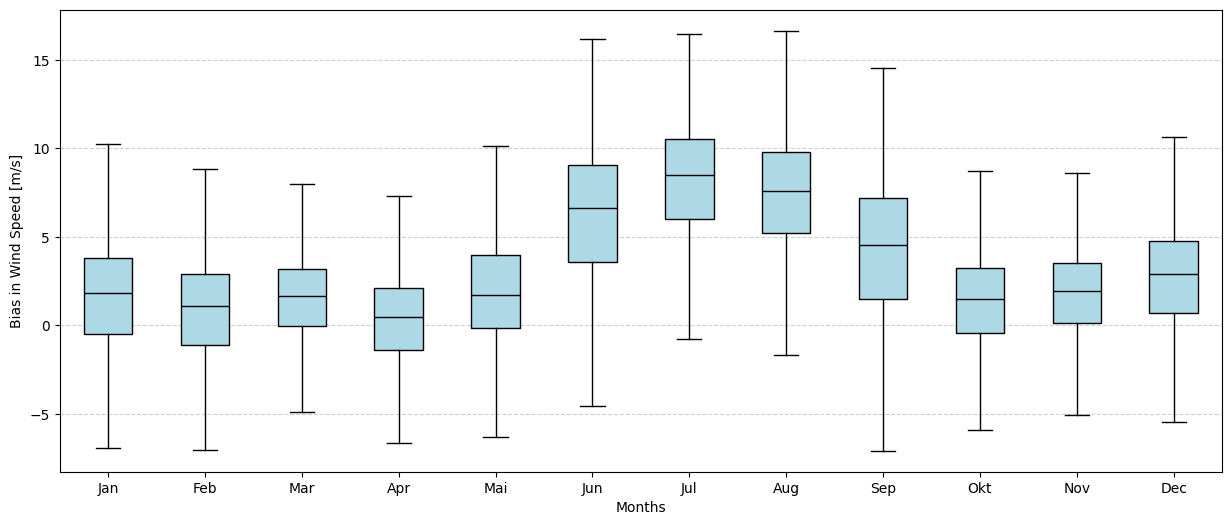

In [10]:
plot_monthly_boxplots(diffs)

In [16]:
diffs_temps_winds = pd.DataFrame(diffs, columns=['bias'])
diffs_temps_winds['temperature_2m'] = temps
diffs_temps_winds['density'] = density
diffs_temps_winds['wind_speed'] = winds
diffs_temps_winds['wind_speed_bin'] = diffs_temps_winds['wind_speed'].apply(lambda x: round(x / 5) * 5)
diffs_temps_winds.index.name = 'timestamp'

In [17]:
diffs_temps_winds.to_csv('results/wind_diffs_and_weather_10m.csv')

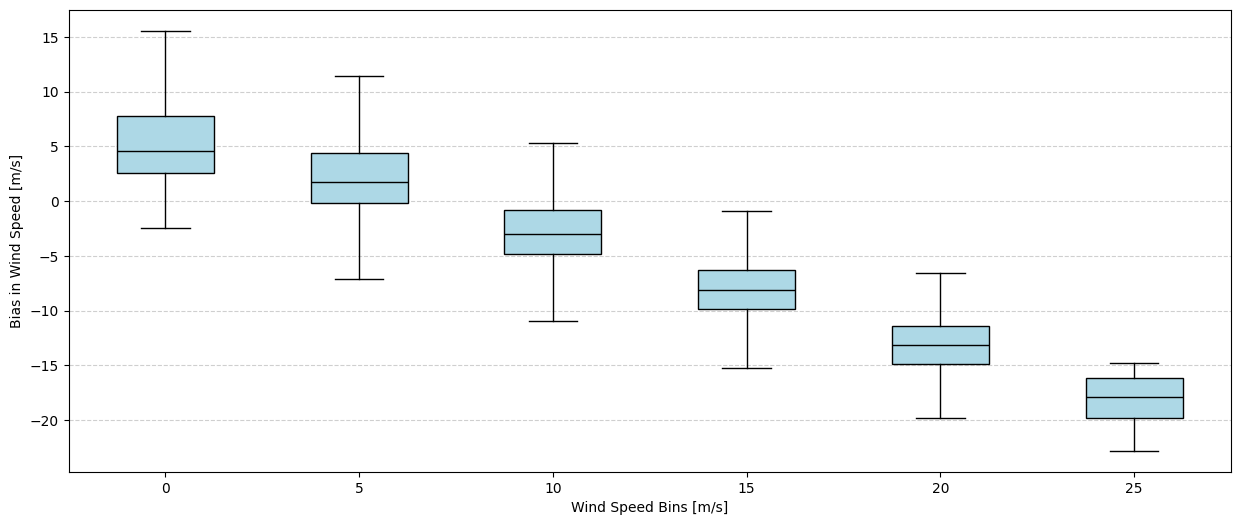

In [14]:
plot_wind_speed_boxplots(data=diffs_temps_winds)

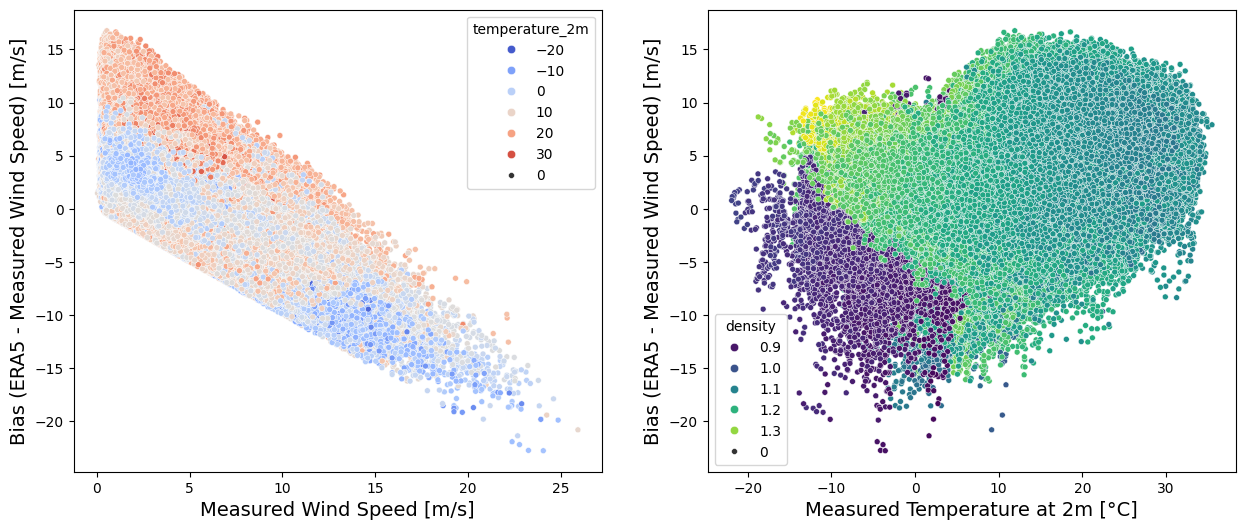

In [28]:
label = 'Measured Temperature at 2m [°C]'
plot_scatter_wind(data=diffs_temps_winds, x='temperature_2m', hue='density', label=label, size=0)

In [ ]:
hours_in_2024 = 8784
plots_target_dir = 'results/scatterplot_10m'
label = 'Measured Temperature at 2m [°C]'
os.makedirs(plots_target_dir, exist_ok=True)
for file, index in zip(station_files_synthetic, range(len(diffs_temps_winds)//hours_in_2024)):
    station_id = file.split('.')[0][-5:]
    df_year = diffs_temps_winds[index*hours_in_2024:hours_in_2024*(index+1)]
    save_path = os.path.join(plots_target_dir, f'scatter_{station_id}')
    #plot_scatter_wind(data=df_year, x='temperature_2m', hue='density', label=label, save_path=save_path)

/Users/viktorwalter/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


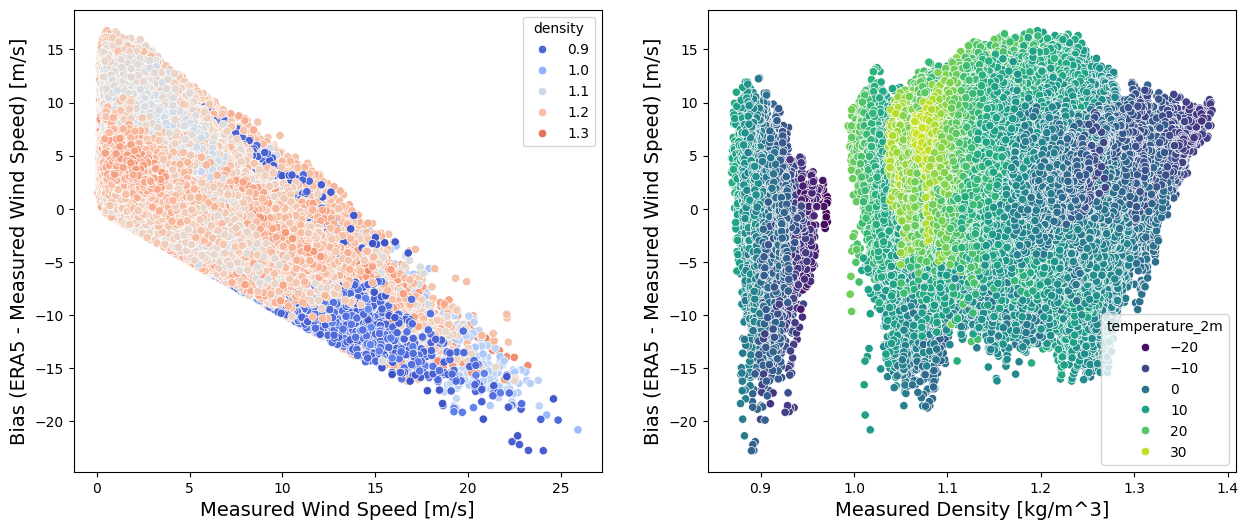

In [ ]:
label = 'Measured Density [kg/m^3]'
plot_scatter_wind(data=diffs_temps_winds, x='density', hue='temperature_2m', label=label)

In [ ]:
hours_in_2024 = 8784
plots_target_dir = 'results/scatterplot_density_10m'
label = 'Measured Density [kg/m^3]'
os.makedirs(plots_target_dir, exist_ok=True)
for file, index in zip(station_files_synthetic, range(len(diffs_temps_winds)//hours_in_2024)):
    station_id = file.split('.')[0][-5:]
    df_year = diffs_temps_winds[index*hours_in_2024:hours_in_2024*(index+1)]
    save_path = os.path.join(plots_target_dir, f'scatter_{station_id}')
    plot_scatter_wind(data=df_year, x='density', hue='temperature_2m', label=label, save_path=save_path)

In [ ]:
fig = px.scatter_3d(
    diffs_temps_winds,
    x='temperature_2m',
    y='wind_speed',
    z='bias',
    color='bias',
    opacity=0.7
)

fig.update_layout(
    scene=dict(
        xaxis_title='Temperature [°C]',
        yaxis_title='Wind Speed [m/s]',
        zaxis_title='Bias [m/s]'
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    title='Interactive 3D Scatterplot'
)

fig.show()

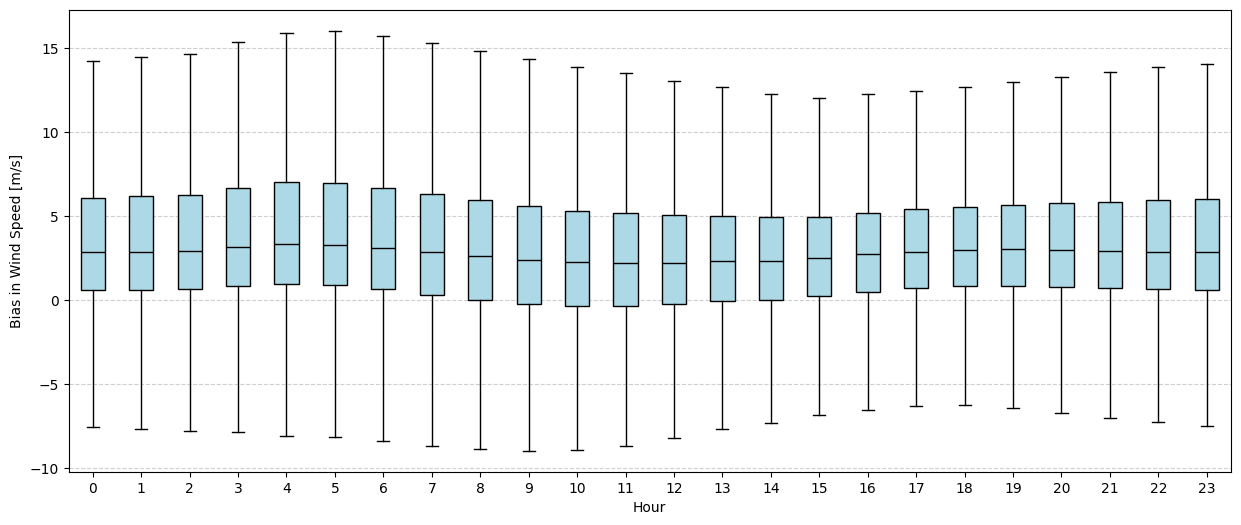

In [ ]:
plot_hourly_boxplots(diffs)

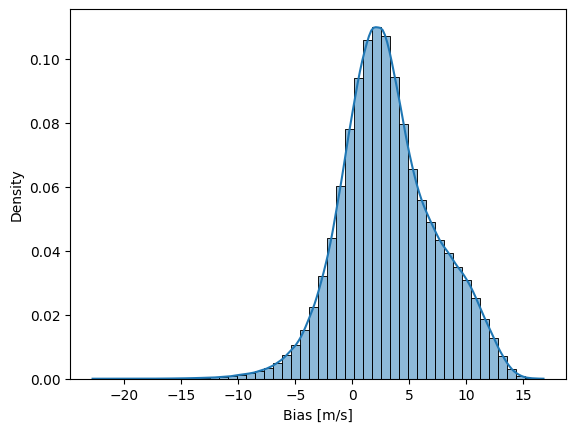

In [ ]:
sns.histplot(data=diffs, stat='density', bins=50, kde=True)
plt.xlabel('Bias [m/s]')
plt.show()

In [ ]:
station_id = '00161'
not_found = False
for idx, file in enumerate(station_files_synthetic):
    if station_id in file:
        not_found = True
        break
if not_found:
    nr = idx
else:
    print(f'Station {station_id} not found.')

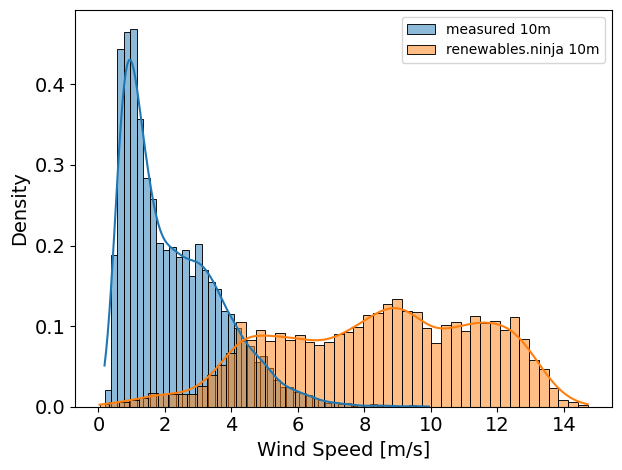

In [ ]:
plot_wind_speed_distribution(dfs[nr], val_dfs[nr])

In [ ]:
bias = val_dfs[nr]['wind_speed'] - dfs[nr]['wind_speed']

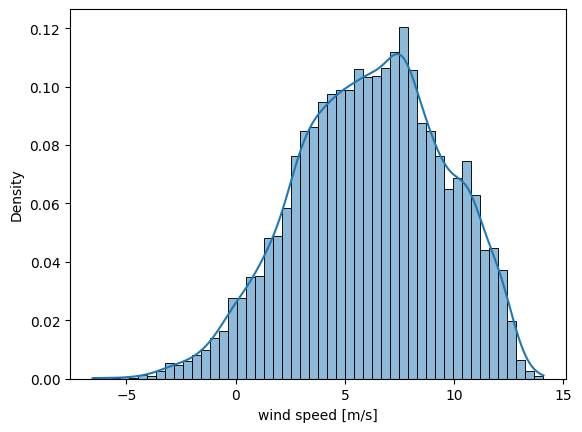

In [ ]:
sns.histplot(data=bias, stat='density', bins=50, kde=True)
plt.xlabel('wind speed [m/s]')
plt.show()

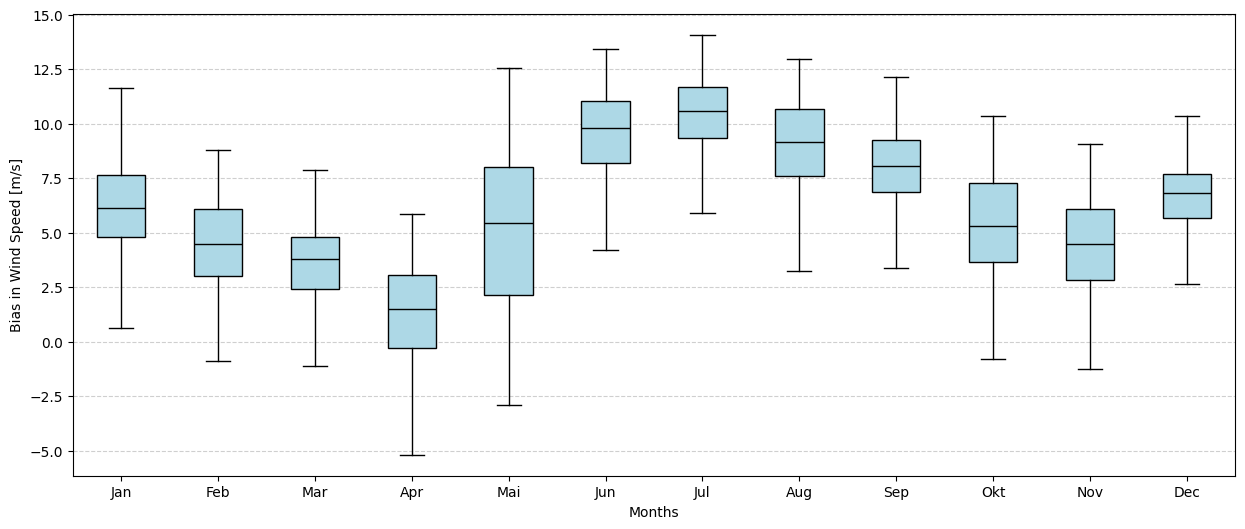

In [ ]:
plot_monthly_boxplots(bias)